In [1]:
import json
import lzma
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from IPython.core.display import display, HTML
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as ticker

import unicodedata
import re
import numpy as np
import os
import io
import time

Using TensorFlow backend.


In [2]:
def text_cleaner(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [3]:
# experimenting
text = 'my text \n yes.!$'
text_cleaner(text)

'<start> my text yes . ! <end>'

In [4]:
def get_cases(state, subset=True, num_cases=100):
    cases = []
    with lzma.open(state + '/data/data.jsonl.xz', 'r') as jsonl_file:
        for i, case in enumerate(jsonl_file):
            c = json.loads(str(case, 'utf-8'))

            date = c['decision_date']
            
            headnotes = c['casebody']['data']['head_matter']
            if headnotes == []:
                continue
            headnotes = text_cleaner(headnotes)
            num_head = len(headnotes)
            
            name = text_cleaner(c['name'])
            docket_number = text_cleaner(c['docket_number'])

            opinions = c['casebody']['data']['opinions']
            if opinions == []:
                continue

            opinions = text_cleaner(opinions[0]['text'])
            body = name + docket_number + opinions
            num_body = len(body)
                
            cases.append({'date':date, 'num_head':num_head, 'head':headnotes, 'num_body':num_body, 'body':body})
            if subset == True:
                if i > num_cases:
                    break
        return pd.DataFrame(cases)

In [5]:
df = get_cases('North Carolina', subset=False, num_cases=10)
df.shape

(97586, 5)

In [20]:
df

,date,num_head,head,num_body,body
18615,2003,35,<start> state v . keel no . a <end>,98,<start> state v . keel <end><start> no . a <en...
28904,1983-07-07,35,<start> in re elkins no . a . <end>,92,<start> in re elkins <end><start> no . a <end>...
37918,1901-02,31,<start> eatman v . lamb . <end>,79,<start> eatman v . lamb <end><start> <end><st...
68768,1942-12-21,32,"<start> s . v . williams , <end>",91,<start> s . v . williams <end><start> <end><s...
68800,1943-05-03,33,"<start> brady v . r . r . , <end>",95,<start> brady v . r . r . <end><start> <end><...
78430,1901-02,35,<start> hicks v . burroughs . <end>,83,<start> hicks v . burroughs <end><start> <end...
79030,2007,34,<start> state v . key no . p <end>,91,<start> state v . key <end><start> no . p <end...
80165,2005,34,<start> state v . hames no . <end>,103,<start> state v . hames <end><start> no . <end...
84595,2005,35,<start> state v . cobb no . p <end>,104,<start> state v . cobb <end><start> no . p <en...
85149,2005,35,<start> state v . pope no . p <end>,82,<start> state v . pope <end><start> no . p <en...


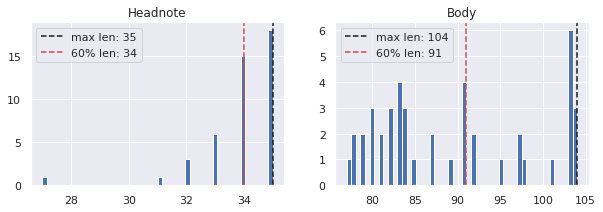

In [19]:
q = 60
q_head = int(np.percentile(df.num_head,q))
q_body = int(np.percentile(df.num_body,q))

f, ax = plt.subplots(1,2,figsize=[10,3])
ax[0].hist(df.num_head, bins=50)
ax[0].axvline(np.max(df.num_head), label='max len: ' + str(np.max(df.num_head)), color='k', ls='--')
ax[0].axvline(q_head, label=str(q) + '% len: ' + str(q_head), color='r', ls='--')
ax[0].set_title('Headnote')
ax[0].legend()
ax[1].hist(df.num_body, bins=50)
ax[1].axvline(np.max(df.num_body), label='max len: ' + str(np.max(df.num_body)), color='k', ls='--')
ax[1].axvline(q_body, label=str(q) + '% len: ' + str(q_body), color='r', ls='--')
ax[1].legend()
ax[1].set_title('Body')
plt.show()

In [17]:
# limiting the dataset
max_head = q_head
max_body = q_body

df = df[(df['num_head'] <= q_head) & (df['num_head'] > 4) & 
        (df['num_body'] <= q_body) & (df['num_body'] > 4)]
print(df.shape)
display(df[['num_head']].describe().T)
display(df[['num_body']].describe().T)

(44, 5)


,count,mean,std,min,25%,50%,75%,max
num_head,44.0,33.909091,1.475666,27.0,33.75,34.0,35.0,35.0


,count,mean,std,min,25%,50%,75%,max
num_body,44.0,89.477273,9.163854,77.0,82.0,87.0,97.25,104.0


11
23


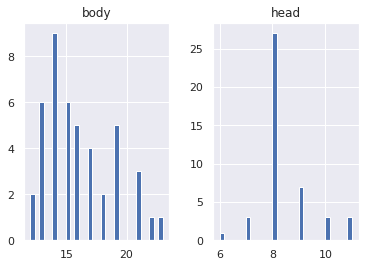

In [18]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['body']:
      text_word_count.append(len(i.split()))

for i in df['head']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'body':text_word_count, 'head':summary_word_count})
max_length_targ = length_df['head'].max()
max_length_inp = length_df['body'].max()
print(max_length_targ)
print(max_length_inp)
length_df.hist(bins = 30)
plt.show()

In [14]:
def tokenize(data):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(data)

    tensor = tokenizer.texts_to_sequences(data)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

input_tensor, inp_lang = tokenize(df['body'])
target_tensor, targ_lang = tokenize(df['head'])

# input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
max_length_targ, max_length_inp

(12, 32)

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

293 293 74 74


In [12]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 500
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 349]), TensorShape([64, 65]))

# Model

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 349, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [17]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 349, 1)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 13123)


In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

In [22]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                     maxlen=max_length_inp,
                                                     padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot